# Computational Cognitive Neuroscience: assignment 1

By: Emiel Stoelinga, s4837584

In this assignment, a multilayer perceptron is trained to predict handwritten digits from the MNIST dataset. The network should contain one hidden layer with 10 hidden units. The output of the network is a prediction of which digit the input image represents.

First the required libraries are imported.

In [2]:
%matplotlib inline

import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples

from utils import get_mnist

import matplotlib.pyplot as plt

Then, a class is constructed which represents the network. The network consist of an input layer, a hidden layer and an output layer.

In [3]:
class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(None, n_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

In order to train the network, a training function is built. For every epoch, the function forwards a new mini-batch through the network, computes the loss and backwards the loss through the network such that variables can be updated. Furthermore, the network is evaluated by forwarding the test set of 100 images through it.

For both operations, the loss is printed and stored, such that it can be plotted after training. 

In [22]:
def run(train_iter, val_iter, test_data, model, optimizer, max_epoch):
    training_losses = []
    validation_losses = []

    batch_losses = []
    
    while train_iter.epoch < max_epoch:
        # Get next mini-batch
        batch = train_iter.next()
        image_train, target_train = concat_examples(batch)

        # Prediction
        prediction_train = model(image_train)

        # Compute loss
        loss = F.softmax_cross_entropy(prediction_train, target_train)
        batch_losses.append(loss.data)

        # Compute gradients
        model.cleargrads()
        loss.backward()

        # Update variables
        optimizer.update()

        # Check the validation accuracy of prediction after every epoch
        if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

            # Display the training loss
            print('epoch:{:02d} train_loss:{:.04f} '.format(train_iter.epoch, np.mean(batch_losses)))
            training_losses.append(np.mean(batch_losses))
            batch_losses = []

            val_losses = []
            val_accuracies = []
            while True:
                val_batch = val_iter.next()
                image_val, target_val = concat_examples(val_batch)

                # Forward the validation data
                prediction_val = model(image_val)

                # Calculate the loss
                loss_val = F.softmax_cross_entropy(prediction_val, target_val)
                val_losses.append(loss_val.data)

                # Calculate the accuracy
                accuracy = F.accuracy(prediction_val, target_val)
                val_accuracies.append(accuracy.data)

                if val_iter.is_new_epoch:
                    val_iter.epoch = 0
                    val_iter.current_position = 0
                    val_iter.is_new_epoch = False
                    val_iter._pushed_position = None

                    validation_losses.append(np.mean(val_losses))
                    break

            print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(np.mean(val_losses), np.mean(val_accuracies)))

    # Predict full test set
    image_test, target_test = concat_examples(test_data)
    # Forward test data
    prediction_test = model(image_test)
    # Calculate loss and accuracy
    loss_test = F.softmax_cross_entropy(prediction_test, target_test)
    accuracy_test = F.accuracy(prediction_test, target_test)

    print('test_loss: ' + str(loss_test.data) + ' test_accuracy: ' + str(accuracy_test.data))
    return training_losses, validation_losses

The full proces is called in the main function. First, the data is downloaded. Then, iterators are constructed which iterate over the data for every epoch. Then the model and the optimizer are constructed and last, the model is trained. 

epoch:01 train_loss:2.2762 
val_loss:2.2624 val_accuracy:0.1340
epoch:02 train_loss:2.2020 
val_loss:2.2012 val_accuracy:0.1730
epoch:03 train_loss:2.1292 
val_loss:2.1457 val_accuracy:0.1960
epoch:04 train_loss:2.0533 
val_loss:2.0919 val_accuracy:0.2020
epoch:05 train_loss:1.9874 
val_loss:2.0374 val_accuracy:0.2270
epoch:06 train_loss:1.9280 
val_loss:1.9856 val_accuracy:0.2380
epoch:07 train_loss:1.8670 
val_loss:1.9374 val_accuracy:0.2620
epoch:08 train_loss:1.8041 
val_loss:1.8871 val_accuracy:0.3010
epoch:09 train_loss:1.7569 
val_loss:1.8382 val_accuracy:0.3280
epoch:10 train_loss:1.6798 
val_loss:1.7939 val_accuracy:0.3420
epoch:11 train_loss:1.6486 
val_loss:1.7498 val_accuracy:0.3570
epoch:12 train_loss:1.5893 
val_loss:1.7062 val_accuracy:0.3720
epoch:13 train_loss:1.5398 
val_loss:1.6659 val_accuracy:0.3980
epoch:14 train_loss:1.4930 
val_loss:1.6201 val_accuracy:0.4340
epoch:15 train_loss:1.4414 
val_loss:1.5802 val_accuracy:0.4550
epoch:16 train_loss:1.3918 
val_loss:1.5

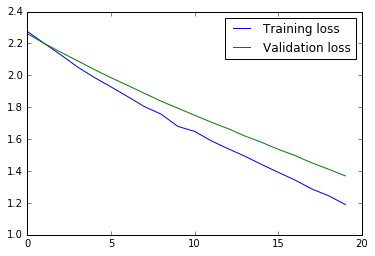

In [23]:
def main():
    # Load data
    train, test = get_mnist()
    
    # Initialize iterators
    train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
    val_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

    # Define model
    model = MLP(10, 10)
    optimizer = optimizers.SGD()
    optimizer.setup(model)

    training_losses, validation_losses = run(train_iter, val_iter, test, model, optimizer, 20)
    
    plt.plot(training_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    plt.legend()

if __name__ == "__main__":
    main()

## Results
As can be seen in the figure, both the training loss and the validation loss descend. Because the network iterates over only a part of the training set per epoch, bumps occur in the slope of the training loss. Due to the small hills in the training loss during the training process, the weights in the network are additionaly adjusted. That the network is succesfully training can be seen in the descending slope of the validation loss. The longer the network trains, the higher its performance in predicting the digits in the dataset.  

### Sources
Chainer: Example: Multi-layer Perceptron on MNIST
https://docs.chainer.org/en/stable/tutorial/basic.html#example-multi-layer-perceptron-on-mnist

Chainer: Write a training loop
https://docs.chainer.org/en/stable/tutorial/train_loop.html#write-a-training-loop